1. Write a Python program that loads a dataset, splits it into training and testing sets, applies Logistic Regression, and prints the model accuracy.

In [2]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, cohen_kappa_score, matthews_corrcoef, precision_recall_curve, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import joblib # For saving and loading models

# Common settings for plots
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# Load the 'iris' dataset from seaborn (we'll make it a binary classification problem)
iris = sns.load_dataset('iris')

# For binary classification, let's use two species: 'setosa' and 'versicolor'
# and try to predict 'species'
df_iris_binary = iris[iris['species'].isin(['setosa', 'versicolor'])].copy() # Use .copy() to avoid SettingWithCopyWarning

# Encode the target variable 'species'
le = LabelEncoder()
df_iris_binary['species_encoded'] = le.fit_transform(df_iris_binary['species'])
# setosa -> 0, versicolor -> 1

# Define features (X) and target (y)
X_iris = df_iris_binary[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y_iris = df_iris_binary['species_encoded']

# Split the dataset into training and testing sets
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42, stratify=y_iris
)

# Initialize and train the Logistic Regression model
log_reg_model_iris = LogisticRegression(random_state=42, solver='liblinear') # liblinear is good for small datasets
log_reg_model_iris.fit(X_train_iris, y_train_iris)

# Make predictions on the test set
y_pred_iris = log_reg_model_iris.predict(X_test_iris)

# Calculate and print the model accuracy
accuracy_iris = accuracy_score(y_test_iris, y_pred_iris)
print(f"Dataset: Iris (setosa vs versicolor)")
print(f"Logistic Regression Model Accuracy: {accuracy_iris:.4f}")

# Display the actual vs predicted for a few samples
print("\nSample Predictions:")
for i in range(5):
    actual_label = le.inverse_transform([y_test_iris.iloc[i]])[0]
    predicted_label = le.inverse_transform([y_pred_iris[i]])[0]
    print(f"Actual: {actual_label}, Predicted: {predicted_label}")

Dataset: Iris (setosa vs versicolor)
Logistic Regression Model Accuracy: 1.0000

Sample Predictions:
Actual: setosa, Predicted: setosa
Actual: setosa, Predicted: setosa
Actual: versicolor, Predicted: versicolor
Actual: setosa, Predicted: setosa
Actual: setosa, Predicted: setosa


2. Write a Python program to apply L1 regularization (Lasso) on a dataset using LogisticRegression (penalty='l1') and print the model accuracy.

In [4]:
# Load the 'breast_cancer' dataset from scikit-learn (binary classification)
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df_cancer = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df_cancer['target'] = cancer.target # 0 for malignant, 1 for benign

# Define features (X) and target (y)
X_cancer = df_cancer.drop('target', axis=1)
y_cancer = df_cancer['target']

# Split the dataset
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.3, random_state=42, stratify=y_cancer
)

# Scale the features (important for regularization and solvers like 'saga' or 'liblinear' with L1)
scaler_cancer = StandardScaler()
X_train_cancer_scaled = scaler_cancer.fit_transform(X_train_cancer)
X_test_cancer_scaled = scaler_cancer.transform(X_test_cancer)

# Initialize and train Logistic Regression with L1 regularization
# 'liblinear' and 'saga' solvers support L1 penalty.
# C is the inverse of regularization strength; smaller C means stronger regularization.
log_reg_l1 = LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state=42)
log_reg_l1.fit(X_train_cancer_scaled, y_train_cancer)

# Make predictions
y_pred_l1 = log_reg_l1.predict(X_test_cancer_scaled)

# Calculate and print model accuracy
accuracy_l1 = accuracy_score(y_test_cancer, y_pred_l1)
print(f"Dataset: Breast Cancer")
print(f"Logistic Regression with L1 (Lasso) Regularization Accuracy: {accuracy_l1:.4f}")

# Print the number of non-zero coefficients to see the effect of L1
num_non_zero_coeffs_l1 = np.sum(log_reg_l1.coef_ != 0)
print(f"Number of features: {X_cancer.shape[1]}")
print(f"Number of non-zero coefficients with L1 (C=0.5): {num_non_zero_coeffs_l1}")

# Try with stronger L1 regularization (smaller C)
log_reg_l1_strong = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42)
log_reg_l1_strong.fit(X_train_cancer_scaled, y_train_cancer)
y_pred_l1_strong = log_reg_l1_strong.predict(X_test_cancer_scaled)
accuracy_l1_strong = accuracy_score(y_test_cancer, y_pred_l1_strong)
num_non_zero_coeffs_l1_strong = np.sum(log_reg_l1_strong.coef_ != 0)

print(f"\nLogistic Regression with stronger L1 (C=0.1) Accuracy: {accuracy_l1_strong:.4f}")
print(f"Number of non-zero coefficients with L1 (C=0.1): {num_non_zero_coeffs_l1_strong}")

Dataset: Breast Cancer
Logistic Regression with L1 (Lasso) Regularization Accuracy: 0.9649
Number of features: 30
Number of non-zero coefficients with L1 (C=0.5): 9

Logistic Regression with stronger L1 (C=0.1) Accuracy: 0.9591
Number of non-zero coefficients with L1 (C=0.1): 7


3. Write a Python program to train Logistic Regression with L2 regularization (Ridge) using LogisticRegression (penalty='l2'). Print model accuracy and coefficients.

In [5]:
# Using the same 'breast_cancer' dataset and split from Q2 for consistency
# Features X_cancer, y_cancer, X_train_cancer_scaled, X_test_cancer_scaled, y_train_cancer, y_test_cancer are already defined and scaled.

# Initialize and train Logistic Regression with L2 regularization (Ridge)
# 'lbfgs' is a common default solver that supports L2.
# C is the inverse of regularization strength.
log_reg_l2 = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', random_state=42, max_iter=1000)
log_reg_l2.fit(X_train_cancer_scaled, y_train_cancer)

# Make predictions
y_pred_l2 = log_reg_l2.predict(X_test_cancer_scaled)

# Calculate and print model accuracy
accuracy_l2 = accuracy_score(y_test_cancer, y_pred_l2)
print(f"Dataset: Breast Cancer")
print(f"Logistic Regression with L2 (Ridge) Regularization Accuracy (C=1.0): {accuracy_l2:.4f}")

# Print the model coefficients
print("\nModel Coefficients (L2 Regularization):")
for feature, coef in zip(cancer.feature_names, log_reg_l2.coef_[0]):
    print(f"{feature}: {coef:.4f}")

# Number of non-zero coefficients (L2 usually doesn't make them exactly zero)
num_non_zero_coeffs_l2 = np.sum(log_reg_l2.coef_ != 0)
print(f"\nNumber of non-zero coefficients with L2 (C=1.0): {num_non_zero_coeffs_l2}")
print(f"Total number of features: {X_cancer.shape[1]}")

Dataset: Breast Cancer
Logistic Regression with L2 (Ridge) Regularization Accuracy (C=1.0): 0.9883

Model Coefficients (L2 Regularization):
mean radius: -0.4950
mean texture: -0.4598
mean perimeter: -0.4598
mean area: -0.5498
mean smoothness: -0.1672
mean compactness: 0.6527
mean concavity: -0.5326
mean concave points: -0.6307
mean symmetry: -0.1138
mean fractal dimension: 0.0362
radius error: -0.8864
texture error: 0.3678
perimeter error: -0.2050
area error: -0.9375
smoothness error: -0.1850
compactness error: 0.5687
concavity error: 0.1637
concave points error: -0.2682
symmetry error: 0.3249
fractal dimension error: 0.3496
worst radius: -0.9411
worst texture: -1.2263
worst perimeter: -0.7310
worst area: -0.9550
worst smoothness: -0.7490
worst compactness: 0.0359
worst concavity: -0.7860
worst concave points: -0.9968
worst symmetry: -0.8694
worst fractal dimension: -0.1643

Number of non-zero coefficients with L2 (C=1.0): 30
Total number of features: 30


4. Write a Python program to train Logistic Regression with Elastic Net Regularization (penalty='elasticnet').

In [6]:
# Continue with the scaled 'breast_cancer' dataset from Q2/Q3.

# Initialize and train Logistic Regression with Elastic Net regularization
# 'saga' solver is required for 'elasticnet' penalty.
# 'l1_ratio' parameter specifies the mix between L1 and L2.
# l1_ratio = 0 corresponds to L2 penalty.
# l1_ratio = 1 corresponds to L1 penalty.
# 0 < l1_ratio < 1 is a combination.
log_reg_elastic = LogisticRegression(
    penalty='elasticnet',
    C=0.5,  # Overall regularization strength
    solver='saga',
    l1_ratio=0.5,  # Mix: 50% L1, 50% L2
    random_state=42,
    max_iter=5000 # saga solver might need more iterations to converge
)
log_reg_elastic.fit(X_train_cancer_scaled, y_train_cancer)

# Make predictions
y_pred_elastic = log_reg_elastic.predict(X_test_cancer_scaled)

# Calculate and print model accuracy
accuracy_elastic = accuracy_score(y_test_cancer, y_pred_elastic)
print(f"Dataset: Breast Cancer")
print(f"Logistic Regression with Elastic Net (C=0.5, l1_ratio=0.5) Accuracy: {accuracy_elastic:.4f}")

# Print the number of non-zero coefficients
num_non_zero_coeffs_elastic = np.sum(log_reg_elastic.coef_ != 0)
print(f"Number of features: {X_cancer.shape[1]}")
print(f"Number of non-zero coefficients with Elastic Net: {num_non_zero_coeffs_elastic}")

# Print the model coefficients
print("\nModel Coefficients (Elastic Net Regularization):")
for feature, coef in zip(cancer.feature_names, log_reg_elastic.coef_[0]):
    print(f"{feature}: {coef:.4f}")

Dataset: Breast Cancer
Logistic Regression with Elastic Net (C=0.5, l1_ratio=0.5) Accuracy: 0.9825
Number of features: 30
Number of non-zero coefficients with Elastic Net: 20

Model Coefficients (Elastic Net Regularization):
mean radius: -0.4061
mean texture: -0.3237
mean perimeter: -0.3348
mean area: -0.4410
mean smoothness: 0.0000
mean compactness: 0.0000
mean concavity: -0.1302
mean concave points: -0.4751
mean symmetry: 0.0000
mean fractal dimension: 0.0000
radius error: -0.5638
texture error: 0.1671
perimeter error: 0.0000
area error: -0.6475
smoothness error: -0.0433
compactness error: 0.3501
concavity error: 0.0000
concave points error: 0.0000
symmetry error: 0.0000
fractal dimension error: 0.1114
worst radius: -0.9746
worst texture: -0.9680
worst perimeter: -0.7216
worst area: -0.8871
worst smoothness: -0.7339
worst compactness: 0.0000
worst concavity: -0.4383
worst concave points: -1.0230
worst symmetry: -0.5466
worst fractal dimension: 0.0000


5. Write a Python program to train a Logistic Regression model for multiclass classification using multi_class = 'ovr'.

In [7]:
# Load the full 'iris' dataset from seaborn (3 classes)
iris_full = sns.load_dataset('iris')

# Encode the target variable 'species'
le_multi = LabelEncoder()
iris_full['species_encoded'] = le_multi.fit_transform(iris_full['species'])
# setosa -> 0, versicolor -> 1, virginica -> 2

# Define features (X) and target (y)
X_iris_multi = iris_full[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y_iris_multi = iris_full['species_encoded']

# Split the dataset
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_iris_multi, y_iris_multi, test_size=0.3, random_state=42, stratify=y_iris_multi
)

# Scale the features
scaler_multi = StandardScaler()
X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi)
X_test_multi_scaled = scaler_multi.transform(X_test_multi)

# Initialize and train Logistic Regression for multiclass classification using 'ovr'
# 'liblinear' solver works well with 'ovr' for smaller datasets.
log_reg_ovr = LogisticRegression(
    multi_class='ovr', # One-vs-Rest strategy
    solver='liblinear',
    C=1.0,
    random_state=42
)
log_reg_ovr.fit(X_train_multi_scaled, y_train_multi)

# Make predictions
y_pred_ovr = log_reg_ovr.predict(X_test_multi_scaled)

# Calculate and print model accuracy
accuracy_ovr = accuracy_score(y_test_multi, y_pred_ovr)
print(f"Dataset: Iris (Multiclass)")
print(f"Logistic Regression with multi_class='ovr' Accuracy: {accuracy_ovr:.4f}")

# Show classification report for more details
print("\nClassification Report (OvR):")
print(classification_report(y_test_multi, y_pred_ovr, target_names=le_multi.classes_))

# The log_reg_ovr model will have 3 sets of coefficients if there are 3 classes
print(f"\nShape of coefficients for OvR with 3 classes: {log_reg_ovr.coef_.shape}")
# Each row corresponds to the coefficients for one of the binary OvR classifiers.

Dataset: Iris (Multiclass)
Logistic Regression with multi_class='ovr' Accuracy: 0.8000

Classification Report (OvR):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.75      0.60      0.67        15
   virginica       0.67      0.80      0.73        15

    accuracy                           0.80        45
   macro avg       0.81      0.80      0.80        45
weighted avg       0.81      0.80      0.80        45


Shape of coefficients for OvR with 3 classes: (3, 4)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


6. Write a Python program to apply GridSearchCV to tune the hyperparameters (C and penalty) of Logistic Regression. Print the best parameters and accuracy.

In [ ]:
# Using the 'breast_cancer' dataset and scaled splits from Q2.
# X_train_cancer_scaled, X_test_cancer_scaled, y_train_cancer, y_test_cancer

# Define the parameter grid for GridSearchCV
# Note: Some solvers only support certain penalties.
# 'liblinear' supports 'l1' and 'l2'.
# 'lbfgs', 'newton-cg', 'sag' support 'l2'.
# 'saga' supports 'l1', 'l2', 'elasticnet'.
# We'll stick to 'liblinear' for simplicity with 'l1'/'l2' penalties here.

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # Inverse of regularization strength
    'penalty': ['l1', 'l2'],             # Regularization type
    'solver': ['liblinear']              # Solver that supports both l1 and l2
}

# Initialize Logistic Regression model (it will be configured by GridSearchCV)
log_reg_for_grid = LogisticRegression(random_state=42, max_iter=1000)

# Initialize GridSearchCV
# cv=5 means 5-fold cross-validation
# scoring='accuracy' means we want to optimize for accuracy
grid_search_lr = GridSearchCV(
    estimator=log_reg_for_grid,
    param_grid=param_grid_lr,
    scoring='accuracy',
    cv=5,         # 5-fold cross-validation
    verbose=1,    # To see some output during the process
    n_jobs=-1     # Use all available CPU cores
)

# Fit GridSearchCV to the training data
grid_search_lr.fit(X_train_cancer_scaled, y_train_cancer)

# Print the best parameters found by GridSearchCV
print(f"\nDataset: Breast Cancer")
print(f"Best parameters found by GridSearchCV: {grid_search_lr.best_params_}")

# Print the best cross-validation accuracy
print(f"Best cross-validation accuracy: {grid_search_lr.best_score_:.4f}")

# Evaluate the best model found by GridSearchCV on the test set
best_lr_model = grid_search_lr.best_estimator_
y_pred_best_lr = best_lr_model.predict(X_test_cancer_scaled)
test_accuracy_best_lr = accuracy_score(y_test_cancer, y_pred_best_lr)
print(f"Test set accuracy of the best model: {test_accuracy_best_lr:.4f}")

7. Write a Python program to evaluate Logistic Regression using Stratified K-Fold Cross-Validation. Print the average accuracy.

In [8]:
# Using the 'penguins' dataset from seaborn for a potentially more challenging classification.
penguins = sns.load_dataset('penguins')

# Preprocessing:
# Drop rows with any missing values for simplicity in this example
penguins_df = penguins.dropna().copy()

# Encode categorical features (island, sex)
penguins_df = pd.get_dummies(penguins_df, columns=['island', 'sex'], drop_first=True)

# Encode the target variable 'species'
le_penguins = LabelEncoder()
penguins_df['species_encoded'] = le_penguins.fit_transform(penguins_df['species'])

# Define features (X) and target (y)
X_penguins = penguins_df.drop(['species', 'species_encoded'], axis=1)
y_penguins = penguins_df['species_encoded']

# Scale the features
scaler_penguins = StandardScaler()
X_penguins_scaled = scaler_penguins.fit_transform(X_penguins)

# Initialize Logistic Regression model
# Using 'lbfgs' solver which supports multinomial for multiclass problems by default.
log_reg_cv = LogisticRegression(random_state=42, solver='lbfgs', multi_class='auto', max_iter=1000)

# Initialize Stratified K-Fold cross-validator
# n_splits=5 means 5 folds. shuffle=True shuffles data before splitting.
# random_state for reproducibility.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get accuracy scores for each fold
# cross_val_score handles the splitting, training, and scoring for each fold.
cv_accuracies = cross_val_score(log_reg_cv, X_penguins_scaled, y_penguins, cv=skf, scoring='accuracy')

# Print the accuracy for each fold and the average accuracy
print(f"Dataset: Penguins (Multiclass)")
print(f"Accuracies for each fold: {cv_accuracies}")
print(f"Average cross-validation accuracy: {cv_accuracies.mean():.4f}")
print(f"Standard deviation of cross-validation accuracy: {cv_accuracies.std():.4f}")

Dataset: Penguins (Multiclass)
Accuracies for each fold: [0.97014925 1.         1.         1.         0.98484848]
Average cross-validation accuracy: 0.9910
Standard deviation of cross-validation accuracy: 0.0120


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

8. Write a Python program to load a dataset from a CSV file, apply Logistic Regression, and evaluate its accuracy.

In [9]:
# Step 1: Create a dummy CSV file
data_for_csv = {
    'feature1': np.random.rand(100) * 10,
    'feature2': np.random.rand(100) * 5,
    'feature3': np.random.rand(100) + 1,
    'target': np.random.randint(0, 2, 100) # Binary target
}
df_to_csv = pd.DataFrame(data_for_csv)
csv_file_path = 'dummy_dataset.csv'
df_to_csv.to_csv(csv_file_path, index=False)
print(f"Dummy CSV file created at: {csv_file_path}")

# Step 2: Load the dataset from the CSV file, apply Logistic Regression, and evaluate
# Load the dataset
try:
    loaded_df = pd.read_csv(csv_file_path)
    print("\nDataset loaded successfully from CSV.")
except FileNotFoundError:
    print(f"Error: The file {csv_file_path} was not found.")
    # Exit or handle error appropriately if file not found
    exit()


# Define features (X) and target (y)
# Assuming the last column is the target and others are features
X_from_csv = loaded_df.iloc[:, :-1] # All columns except the last
y_from_csv = loaded_df.iloc[:, -1]  # The last column

# Check if target is binary
if y_from_csv.nunique() != 2:
    print(f"Warning: The target variable does not seem to be binary (unique values: {y_from_csv.unique()}).")
    # For this example, we'll proceed assuming it's meant for binary classification
    # or that Logistic Regression will handle it (e.g. if it's multiclass and solver supports it)

# Split the dataset
X_train_csv, X_test_csv, y_train_csv, y_test_csv = train_test_split(
    X_from_csv, y_from_csv, test_size=0.25, random_state=42, stratify=y_from_csv if y_from_csv.nunique() > 1 else None
)

# Scale features (good practice)
scaler_csv = StandardScaler()
X_train_csv_scaled = scaler_csv.fit_transform(X_train_csv)
X_test_csv_scaled = scaler_csv.transform(X_test_csv)

# Initialize and train Logistic Regression model
log_reg_csv_model = LogisticRegression(random_state=42, solver='liblinear')
log_reg_csv_model.fit(X_train_csv_scaled, y_train_csv)

# Make predictions
y_pred_csv = log_reg_csv_model.predict(X_test_csv_scaled)

# Evaluate accuracy
accuracy_csv = accuracy_score(y_test_csv, y_pred_csv)
print(f"\nDataset: Loaded from {csv_file_path}")
print(f"Logistic Regression Model Accuracy: {accuracy_csv:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_csv, y_pred_csv))

Dummy CSV file created at: dummy_dataset.csv

Dataset loaded successfully from CSV.

Dataset: Loaded from dummy_dataset.csv
Logistic Regression Model Accuracy: 0.6000

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        11
           1       0.62      0.71      0.67        14

    accuracy                           0.60        25
   macro avg       0.59      0.58      0.58        25
weighted avg       0.59      0.60      0.59        25



9. Write a Python program to apply RandomizedSearchCV for tuning hyperparameters (C, penalty, solver) in Logistic Regression. Print the best parameters and accuracy.

In [10]:
# Using the 'breast_cancer' dataset and scaled splits from Practical Question 2.
# X_train_cancer_scaled, X_test_cancer_scaled, y_train_cancer, y_test_cancer

# Define the parameter distributions for RandomizedSearchCV
# Note on solvers and penalties:
# 'liblinear' supports 'l1', 'l2'
# 'saga' supports 'l1', 'l2', 'elasticnet'
# 'lbfgs', 'newton-cg', 'sag' support 'l2' or 'none'

param_dist_lr = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100], # List of C values
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'] # Solvers that can handle both l1 and l2
    # We could add 'l1_ratio' if 'elasticnet' was a penalty choice with 'saga'
}
# For a more exhaustive solver search, you might need conditional parameter grids
# or multiple RandomizedSearchCV runs due to solver-penalty compatibility.
# For instance, 'lbfgs' only with 'l2'.

# Initialize Logistic Regression model
log_reg_for_random = LogisticRegression(random_state=42, max_iter=5000) # Increased max_iter for saga

# Initialize RandomizedSearchCV
# n_iter: Number of parameter settings that are sampled.
# cv=5: 5-fold cross-validation
random_search_lr = RandomizedSearchCV(
    estimator=log_reg_for_random,
    param_distributions=param_dist_lr,
    n_iter=20,  # Number of parameter combinations to try (e.g., 20)
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV to the training data
# This might produce warnings if some combinations of solver and penalty are incompatible.
# RandomizedSearchCV will skip incompatible ones if the estimator raises an error.
# A more robust way is to define a list of parameter dictionaries if solvers have strict penalty compatibilities.
print("Starting RandomizedSearchCV... This might show warnings for incompatible solver/penalty pairs.")
random_search_lr.fit(X_train_cancer_scaled, y_train_cancer)

# Print the best parameters found
print(f"\nDataset: Breast Cancer")
print(f"Best parameters found by RandomizedSearchCV: {random_search_lr.best_params_}")

# Print the best cross-validation accuracy
print(f"Best cross-validation accuracy: {random_search_lr.best_score_:.4f}")

# Evaluate the best model on the test set
best_lr_model_random = random_search_lr.best_estimator_
y_pred_best_lr_random = best_lr_model_random.predict(X_test_cancer_scaled)
test_accuracy_best_lr_random = accuracy_score(y_test_cancer, y_pred_best_lr_random)
print(f"Test set accuracy of the best model from RandomizedSearch: {test_accuracy_best_lr_random:.4f}")

Starting RandomizedSearchCV... This might show warnings for incompatible solver/penalty pairs.
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Dataset: Breast Cancer
Best parameters found by RandomizedSearchCV: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.5}
Best cross-validation accuracy: 0.9824
Test set accuracy of the best model from RandomizedSearch: 0.9649


10. Write a Python program to implement One-vs-One (OvO) Multiclass Logistic Regression and print accuracy.

In [11]:
from sklearn.multiclass import OneVsOneClassifier

# Using the full 'iris' dataset (3 classes) and scaled splits from Practical Question 5
# X_train_multi_scaled, X_test_multi_scaled, y_train_multi, y_test_multi
# le_multi (LabelEncoder for iris species)

# Initialize a base Logistic Regression model
# This will be used by OneVsOneClassifier for each pair of classes.
# For OvO, each binary classifier can be simpler. 'liblinear' is a good choice.
base_log_reg_for_ovo = LogisticRegression(solver='liblinear', C=1.0, random_state=42)

# Initialize OneVsOneClassifier with the base Logistic Regression model
ovo_classifier = OneVsOneClassifier(base_log_reg_for_ovo)

# Train the OvO model
ovo_classifier.fit(X_train_multi_scaled, y_train_multi)

# Make predictions
y_pred_ovo = ovo_classifier.predict(X_test_multi_scaled)

# Calculate and print model accuracy
accuracy_ovo = accuracy_score(y_test_multi, y_pred_ovo)
print(f"Dataset: Iris (Multiclass)")
print(f"One-vs-One (OvO) Logistic Regression Accuracy: {accuracy_ovo:.4f}")

# Show classification report
print("\nClassification Report (OvO):")
print(classification_report(y_test_multi, y_pred_ovo, target_names=le_multi.classes_))

# The OvO classifier trains N * (N-1) / 2 models for N classes.
# For Iris (3 classes), it trains 3 * (3-1) / 2 = 3 binary classifiers.
print(f"\nNumber of base estimators in OvO: {len(ovo_classifier.estimators_)}")

Dataset: Iris (Multiclass)
One-vs-One (OvO) Logistic Regression Accuracy: 0.8889

Classification Report (OvO):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.81      0.87      0.84        15
   virginica       0.86      0.80      0.83        15

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45


Number of base estimators in OvO: 3


11. Write a Python program to train a Logistic Regression model and visualize the confusion matrix for binary classification.

Dataset: Breast Cancer (Binary Classification)
Confusion Matrix:
[[ 63   1]
 [  1 106]]


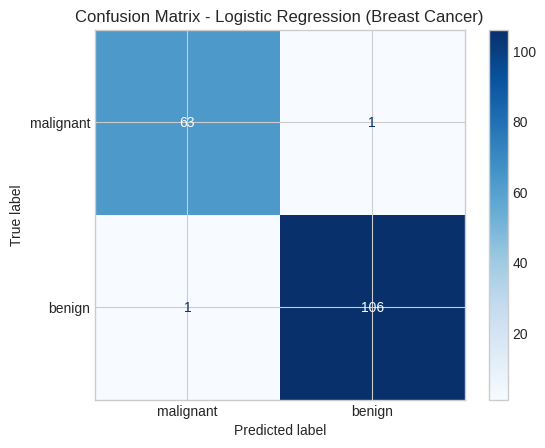

Model Accuracy: 0.9883


In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

# Using the 'breast_cancer' dataset and scaled splits from Practical Question 2
# X_train_cancer_scaled, X_test_cancer_scaled, y_train_cancer, y_test_cancer

# Train a simple Logistic Regression model (can be any from previous Qs, e.g., L2 regularized)
log_reg_for_cm = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', random_state=42, max_iter=1000)
log_reg_for_cm.fit(X_train_cancer_scaled, y_train_cancer)

# Make predictions on the test set
y_pred_cm = log_reg_for_cm.predict(X_test_cancer_scaled)

# Compute the confusion matrix
cm = confusion_matrix(y_test_cancer, y_pred_cm)
print(f"Dataset: Breast Cancer (Binary Classification)")
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cancer.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression (Breast Cancer)")
plt.show()

# Also print accuracy for context
accuracy_cm = accuracy_score(y_test_cancer, y_pred_cm)
print(f"Model Accuracy: {accuracy_cm:.4f}")

12. Write a Python program to train a Logistic Regression model and evaluate its performance using Precision, Recall, and F1-Score.

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Using the 'breast_cancer' dataset and the model from Q11 (log_reg_for_cm)
# y_test_cancer (true labels), y_pred_cm (predicted labels)

print(f"Dataset: Breast Cancer (Binary Classification)")

# Using classification_report (comprehensive)
print("\nClassification Report:")
# target_names are ['malignant', 'benign'] where malignant is 0, benign is 1.
# So, for positive class (label 1, 'benign'):
report = classification_report(y_test_cancer, y_pred_cm, target_names=cancer.target_names)
print(report)

# Calculating individual metrics for the positive class (label 1, which is 'benign' in this dataset)
# By default, these functions assume the positive class label is 1 for binary classification.
# If your positive class is 0, use pos_label=0.
precision_positive = precision_score(y_test_cancer, y_pred_cm, pos_label=1)
recall_positive = recall_score(y_test_cancer, y_pred_cm, pos_label=1)
f1_positive = f1_score(y_test_cancer, y_pred_cm, pos_label=1)

print(f"\nIndividual Metrics for Positive Class ('{cancer.target_names[1]}'):")
print(f"Precision: {precision_positive:.4f}")
print(f"Recall (Sensitivity): {recall_positive:.4f}")
print(f"F1-Score: {f1_positive:.4f}")

# You can also calculate for the other class ('malignant', label 0)
precision_negative = precision_score(y_test_cancer, y_pred_cm, pos_label=0)
recall_negative = recall_score(y_test_cancer, y_pred_cm, pos_label=0) # This is also Specificity if 0 is negative class
f1_negative = f1_score(y_test_cancer, y_pred_cm, pos_label=0)

print(f"\nIndividual Metrics for Negative Class ('{cancer.target_names[0]}'):")
print(f"Precision: {precision_negative:.4f}")
print(f"Recall (Specificity if this is TNR): {recall_negative:.4f}")
print(f"F1-Score: {f1_negative:.4f}")

Dataset: Breast Cancer (Binary Classification)

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        64
      benign       0.99      0.99      0.99       107

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171


Individual Metrics for Positive Class ('benign'):
Precision: 0.9907
Recall (Sensitivity): 0.9907
F1-Score: 0.9907

Individual Metrics for Negative Class ('malignant'):
Precision: 0.9844
Recall (Specificity if this is TNR): 0.9844
F1-Score: 0.9844


13. Write a Python program to train a Logistic Regression model on imbalanced data and apply class weights to improve model performance.

In [14]:
from sklearn.datasets import make_classification

# Step 1: Create an imbalanced dataset
X_imb, y_imb = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=2,
    n_redundant=10,
    n_clusters_per_class=1,
    weights=[0.95, 0.05], # 95% majority class, 5% minority class
    flip_y=0, # No noise
    random_state=42
)

X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imb, y_imb, test_size=0.3, random_state=42, stratify=y_imb
)

# Scale features
scaler_imb = StandardScaler()
X_train_imb_scaled = scaler_imb.fit_transform(X_train_imb)
X_test_imb_scaled = scaler_imb.transform(X_test_imb)

print(f"Original class distribution in training set: {np.bincount(y_train_imb)}")
print(f"Original class distribution in test set: {np.bincount(y_test_imb)}")


# Step 2: Train Logistic Regression without class weights
log_reg_no_weights = LogisticRegression(solver='liblinear', random_state=42)
log_reg_no_weights.fit(X_train_imb_scaled, y_train_imb)
y_pred_no_weights = log_reg_no_weights.predict(X_test_imb_scaled)

print("\n--- Model WITHOUT Class Weights ---")
print("Accuracy:", accuracy_score(y_test_imb, y_pred_no_weights))
print("Classification Report:\n", classification_report(y_test_imb, y_pred_no_weights, zero_division=0))
# Note: zero_division=0 in classification_report handles cases where a class might not be predicted at all.

# Step 3: Train Logistic Regression with class weights
# 'balanced' automatically adjusts weights inversely proportional to class frequencies
log_reg_with_weights = LogisticRegression(
    solver='liblinear',
    class_weight='balanced', # Key parameter
    random_state=42
)
log_reg_with_weights.fit(X_train_imb_scaled, y_train_imb)
y_pred_with_weights = log_reg_with_weights.predict(X_test_imb_scaled)

print("\n--- Model WITH Class Weights ('balanced') ---")
print("Accuracy:", accuracy_score(y_test_imb, y_pred_with_weights))
print("Classification Report:\n", classification_report(y_test_imb, y_pred_with_weights, zero_division=0))

# Alternatively, you can specify weights manually as a dictionary:
# e.g., weights = {0: 1, 1: 10} to give 10x more weight to class 1
# from sklearn.utils.class_weight import compute_class_weight
# unique_classes = np.unique(y_train_imb)
# manual_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train_imb)
# weight_dict = dict(zip(unique_classes, manual_weights))
# print(f"Manually computed weights: {weight_dict}")

# log_reg_manual_weights = LogisticRegression(
#     solver='liblinear',
#     class_weight=weight_dict,
#     random_state=42
# )
# log_reg_manual_weights.fit(X_train_imb_scaled, y_train_imb)
# y_pred_manual_weights = log_reg_manual_weights.predict(X_test_imb_scaled)

# print("\n--- Model WITH Manually Computed Class Weights ---")
# print("Accuracy:", accuracy_score(y_test_imb, y_pred_manual_weights))
# print("Classification Report:\n", classification_report(y_test_imb, y_pred_manual_weights, zero_division=0))

Original class distribution in training set: [665  35]
Original class distribution in test set: [285  15]

--- Model WITHOUT Class Weights ---
Accuracy: 0.9866666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       285
           1       1.00      0.73      0.85        15

    accuracy                           0.99       300
   macro avg       0.99      0.87      0.92       300
weighted avg       0.99      0.99      0.99       300


--- Model WITH Class Weights ('balanced') ---
Accuracy: 0.9566666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       285
           1       0.54      0.87      0.67        15

    accuracy                           0.96       300
   macro avg       0.77      0.91      0.82       300
weighted avg       0.97      0.96      0.96       300



14. Write a Python program to train Logistic Regression on the Titanic dataset, handle missing values, and evaluate performance.

Original Titanic Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB

Missing values before handling:
survived       

<ipython-input-15-8a8aca50644f>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)
<ipython-input-15-8a8aca50644f>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

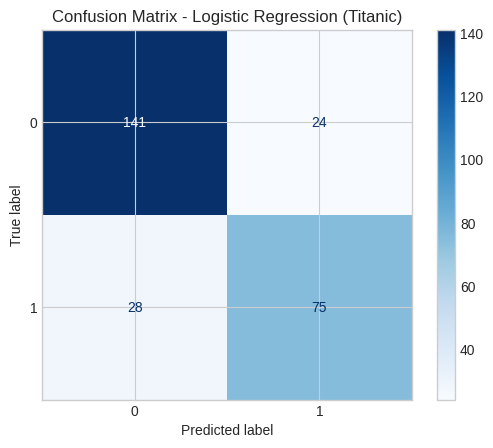

In [15]:
# Load the 'titanic' dataset from seaborn
titanic_df = sns.load_dataset('titanic')

print("Original Titanic Dataset Info:")
titanic_df.info()
print("\nMissing values before handling:")
print(titanic_df.isnull().sum())

# --- Preprocessing and Feature Engineering ---
# 1. Select relevant features
# We'll use: pclass, sex, age, sibsp, parch, fare, embarked, alone
# We'll predict: survived
features_to_use = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'alone']
target = 'survived'

df = titanic_df[features_to_use + [target]].copy()

# 2. Handle missing values
# Age: Impute with the median
df['age'].fillna(df['age'].median(), inplace=True)

# Embarked: Impute with the mode (most frequent)
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)

# 'deck' has too many missing values, so we dropped it by not selecting it.
# 'embark_town' is redundant with 'embarked'.

print("\nMissing values after handling:")
print(df.isnull().sum())

# 3. Convert categorical features to numerical
# Sex: map to 0 and 1
df['sex'] = df['sex'].map({'male': 0, 'female': 1})

# Embarked: one-hot encode
df = pd.get_dummies(df, columns=['embarked'], drop_first=True) # drop_first to avoid multicollinearity

# Alone: boolean to int
df['alone'] = df['alone'].astype(int)

# 4. Define Features (X) and Target (y)
X_titanic = df.drop(target, axis=1)
y_titanic = df[target]

# Ensure all columns are numeric now
print("\nData types after conversion:")
print(X_titanic.dtypes)


# 5. Split data
X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic = train_test_split(
    X_titanic, y_titanic, test_size=0.3, random_state=42, stratify=y_titanic
)

# 6. Scale numerical features (Age and Fare in this case)
# It's good practice to scale features for Logistic Regression
scaler_titanic = StandardScaler()
# Fit on training data and transform both training and testing data
# Identify numerical columns to scale, excluding already encoded binary/boolean columns
numerical_cols = ['age', 'fare', 'pclass', 'sibsp', 'parch'] # pclass, sibsp, parch are ordinal but often scaled
cols_to_scale = [col for col in numerical_cols if col in X_train_titanic.columns]


X_train_titanic_scaled = X_train_titanic.copy()
X_test_titanic_scaled = X_test_titanic.copy()

if cols_to_scale: # Proceed only if there are columns to scale
    X_train_titanic_scaled[cols_to_scale] = scaler_titanic.fit_transform(X_train_titanic[cols_to_scale])
    X_test_titanic_scaled[cols_to_scale] = scaler_titanic.transform(X_test_titanic[cols_to_scale])
else:
    print("No columns identified for scaling.")


# --- Train Logistic Regression Model ---
log_reg_titanic = LogisticRegression(solver='liblinear', random_state=42, C=0.5, penalty='l1')
log_reg_titanic.fit(X_train_titanic_scaled, y_train_titanic)

# --- Evaluate Performance ---
y_pred_titanic = log_reg_titanic.predict(X_test_titanic_scaled)
accuracy_titanic = accuracy_score(y_test_titanic, y_pred_titanic)

print(f"\nDataset: Titanic")
print(f"Logistic Regression Model Accuracy: {accuracy_titanic:.4f}")
print("\nClassification Report (Titanic):")
print(classification_report(y_test_titanic, y_pred_titanic))

print("\nConfusion Matrix (Titanic):")
cm_titanic = confusion_matrix(y_test_titanic, y_pred_titanic)
disp_titanic = ConfusionMatrixDisplay(confusion_matrix=cm_titanic)
disp_titanic.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression (Titanic)")
plt.show()

15. Write a Python program to apply feature scaling (Standardization) before training a Logistic Regression model. Evaluate its accuracy and compare results with and without scaling.

In [16]:
# Using the 'wine' dataset from scikit-learn (multiclass)
from sklearn.datasets import load_wine
wine = load_wine()
df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
df_wine['target'] = wine.target

# Define features (X) and target (y)
X_wine = df_wine.drop('target', axis=1)
y_wine = df_wine['target']

# Split the dataset
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_wine, y_wine, test_size=0.3, random_state=42, stratify=y_wine
)

# --- Model WITHOUT Feature Scaling ---
log_reg_no_scale = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=42, max_iter=5000)
log_reg_no_scale.fit(X_train_w, y_train_w)
y_pred_no_scale = log_reg_no_scale.predict(X_test_w)
accuracy_no_scale = accuracy_score(y_test_w, y_pred_no_scale)

print(f"Dataset: Wine (Multiclass)")
print(f"Accuracy WITHOUT Feature Scaling: {accuracy_no_scale:.4f}")
# print("Coefficients WITHOUT scaling (first 5 features):", log_reg_no_scale.coef_[0, :5])


# --- Model WITH Feature Scaling (Standardization) ---
scaler_wine = StandardScaler()
X_train_w_scaled = scaler_wine.fit_transform(X_train_w)
X_test_w_scaled = scaler_wine.transform(X_test_w)

log_reg_with_scale = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=42, max_iter=5000)
log_reg_with_scale.fit(X_train_w_scaled, y_train_w)
y_pred_with_scale = log_reg_with_scale.predict(X_test_w_scaled)
accuracy_with_scale = accuracy_score(y_test_w, y_pred_with_scale)

print(f"Accuracy WITH Feature Scaling (Standardization): {accuracy_with_scale:.4f}")
# print("Coefficients WITH scaling (first 5 features):", log_reg_with_scale.coef_[0, :5])


# --- Comparison ---
print("\nComparison:")
if accuracy_with_scale > accuracy_no_scale:
    print("Feature scaling improved accuracy.")
elif accuracy_with_scale < accuracy_no_scale:
    print("Feature scaling decreased accuracy (unusual for LR with regularization/certain solvers, but possible).")
else:
    print("Feature scaling did not change accuracy significantly.")

# Note: The impact of scaling can depend on the dataset, the solver, and regularization.
# For solvers like 'sag' and 'saga', scaling is highly recommended for convergence.
# For regularized models (L1/L2), scaling ensures features are penalized appropriately.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Dataset: Wine (Multiclass)
Accuracy WITHOUT Feature Scaling: 0.9630
Accuracy WITH Feature Scaling (Standardization): 0.9815

Comparison:
Feature scaling improved accuracy.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


16. Write a Python program to train Logistic Regression and evaluate its performance using ROC-AUC score.

Dataset: Breast Cancer (Binary Classification)
ROC-AUC Score: 0.9981


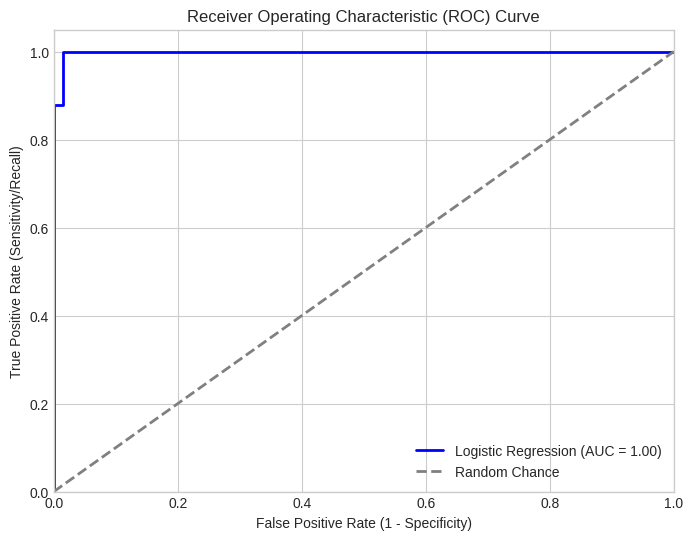

In [17]:
# Using the 'breast_cancer' dataset (binary) and scaled splits from Practical Question 2.
# X_train_cancer_scaled, X_test_cancer_scaled, y_train_cancer, y_test_cancer

# Train a Logistic Regression model
log_reg_roc = LogisticRegression(solver='liblinear', random_state=42)
log_reg_roc.fit(X_train_cancer_scaled, y_train_cancer)

# Get predicted probabilities for the positive class (class 1)
# roc_auc_score needs probability scores of the positive class.
y_pred_proba_roc = log_reg_roc.predict_proba(X_test_cancer_scaled)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test_cancer, y_pred_proba_roc)
print(f"Dataset: Breast Cancer (Binary Classification)")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Visualize the ROC Curve
# RocCurveDisplay.from_estimator(log_reg_roc, X_test_cancer_scaled, y_test_cancer)
# plt.title('ROC Curve - Logistic Regression (Breast Cancer)')
# plt.plot([0, 1], [0, 1], 'k--', label='Random chance') # Line for random guessing
# plt.legend()
# plt.show()

# Alternative way to plot using predicted probabilities
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_cancer, y_pred_proba_roc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

17. Write a Python program to train Logistic Regression using a custom learning rate (C=0.5) and evaluate accuracy.

In [18]:
# Using the 'breast_cancer' dataset and scaled splits from Practical Question 2.
# X_train_cancer_scaled, X_test_cancer_scaled, y_train_cancer, y_test_cancer

# Initialize and train Logistic Regression with C=0.5
# We can choose a penalty type, e.g., 'l2' with a compatible solver.
log_reg_custom_c = LogisticRegression(
    C=0.5,          # Custom inverse of regularization strength
    penalty='l2',   # Example: L2 regularization
    solver='liblinear', # Solver compatible with L2
    random_state=42
)
log_reg_custom_c.fit(X_train_cancer_scaled, y_train_cancer)

# Make predictions
y_pred_custom_c = log_reg_custom_c.predict(X_test_cancer_scaled)

# Evaluate accuracy
accuracy_custom_c = accuracy_score(y_test_cancer, y_pred_custom_c)

print(f"Dataset: Breast Cancer")
print(f"Logistic Regression Accuracy with C=0.5, penalty='l2', solver='liblinear': {accuracy_custom_c:.4f}")

# For demonstration, let's try another combination with C=0.5
log_reg_custom_c_l1 = LogisticRegression(
    C=0.5,
    penalty='l1',
    solver='saga', # Saga supports L1
    random_state=42,
    max_iter=5000 # Saga might need more iterations
)
log_reg_custom_c_l1.fit(X_train_cancer_scaled, y_train_cancer)
y_pred_custom_c_l1 = log_reg_custom_c_l1.predict(X_test_cancer_scaled)
accuracy_custom_c_l1 = accuracy_score(y_test_cancer, y_pred_custom_c_l1)
print(f"Logistic Regression Accuracy with C=0.5, penalty='l1', solver='saga': {accuracy_custom_c_l1:.4f}")

Dataset: Breast Cancer
Logistic Regression Accuracy with C=0.5, penalty='l2', solver='liblinear': 0.9883
Logistic Regression Accuracy with C=0.5, penalty='l1', solver='saga': 0.9708


18. Write a Python program to train Logistic Regression and identify important features based on model coefficients.

Dataset: Breast Cancer

Feature Importances based on L1 Regularized Logistic Regression Coefficients (C=0.1):
                    Feature  Coefficient  Absolute Coefficient
20             worst radius    -2.252041              2.252041
27     worst concave points    -0.934264              0.934264
21            worst texture    -0.488667              0.488667
7       mean concave points    -0.482399              0.482399
24         worst smoothness    -0.247396              0.247396
28           worst symmetry    -0.175771              0.175771
10             radius error    -0.029805              0.029805
5          mean compactness     0.000000              0.000000
8             mean symmetry     0.000000              0.000000
4           mean smoothness     0.000000              0.000000
2            mean perimeter     0.000000              0.000000
3                 mean area     0.000000              0.000000
0               mean radius     0.000000              0.000000
1       

<ipython-input-19-39184fc50a80>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Absolute Coefficient', y='Feature', data=feature_importance_df.head(10), palette='viridis')


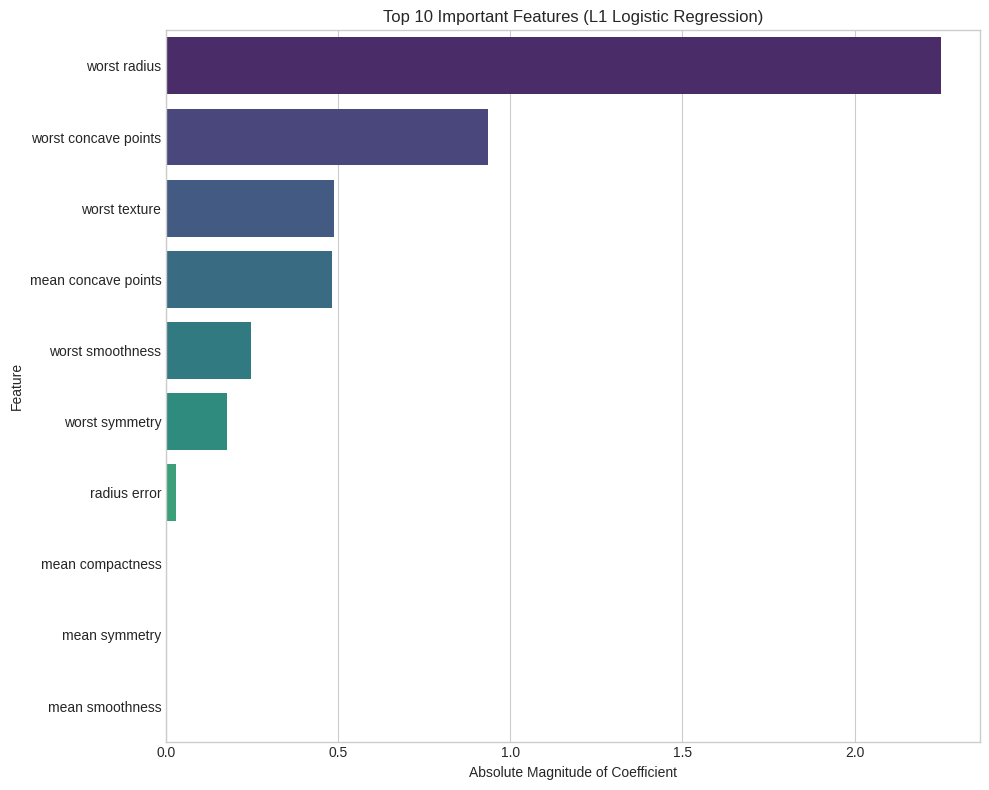


Number of features originally: 30
Number of features selected by L1 (non-zero coefficient): 7

Selected features:
                 Feature  Coefficient
20          worst radius    -2.252041
27  worst concave points    -0.934264
21         worst texture    -0.488667
7    mean concave points    -0.482399
24      worst smoothness    -0.247396
28        worst symmetry    -0.175771
10          radius error    -0.029805


In [19]:
# Using the 'breast_cancer' dataset and scaled splits from Practical Question 2.
# X_train_cancer_scaled, X_test_cancer_scaled, y_train_cancer, y_test_cancer
# cancer.feature_names contains the names of the features.

# Train a Logistic Regression model (L1 regularization is good for feature importance)
log_reg_importance = LogisticRegression(
    penalty='l1',
    C=0.1,  # A moderate to strong C for L1 to see some sparsity
    solver='liblinear', # liblinear works well with L1
    random_state=42
)
log_reg_importance.fit(X_train_cancer_scaled, y_train_cancer)

# Get the coefficients
# For binary classification, coef_ is of shape (1, n_features)
coefficients = log_reg_importance.coef_[0]

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': cancer.feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients to see importance
feature_importance_df['Absolute Coefficient'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='Absolute Coefficient', ascending=False)

print("Dataset: Breast Cancer")
print("\nFeature Importances based on L1 Regularized Logistic Regression Coefficients (C=0.1):")
print(feature_importance_df)

# Visualize feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Absolute Coefficient', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Important Features (L1 Logistic Regression)')
plt.xlabel('Absolute Magnitude of Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Identify features with non-zero coefficients (selected by L1)
selected_features = feature_importance_df[feature_importance_df['Coefficient'] != 0]
print(f"\nNumber of features originally: {len(cancer.feature_names)}")
print(f"Number of features selected by L1 (non-zero coefficient): {len(selected_features)}")
print("\nSelected features:")
print(selected_features[['Feature', 'Coefficient']])

19. Write a Python program to train Logistic Regression and evaluate its performance using Cohen’s Kappa
ScoreM

In [20]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load the Titanic dataset
data = sns.load_dataset('titanic')

# Drop rows with missing target or relevant features
data = data[['survived', 'pclass', 'sex', 'age', 'fare']].dropna()

# Encode categorical variable 'sex'
data['sex'] = LabelEncoder().fit_transform(data['sex'])  # male=1, female=0

# Define features (X) and target (y)
X = data[['pclass', 'sex', 'age', 'fare']]
y = data['survived']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate using Cohen's Kappa Score
kappa_score = cohen_kappa_score(y_test, y_pred)

# Display results
print("Cohen's Kappa Score:", round(kappa_score, 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Cohen's Kappa Score: 0.491

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80        87
           1       0.68      0.71      0.70        56

    accuracy                           0.76       143
   macro avg       0.74      0.75      0.75       143
weighted avg       0.76      0.76      0.76       143



20. Write a Python program to train Logistic Regression and visualize the Precision-Recall Curve for binary
classificatio:

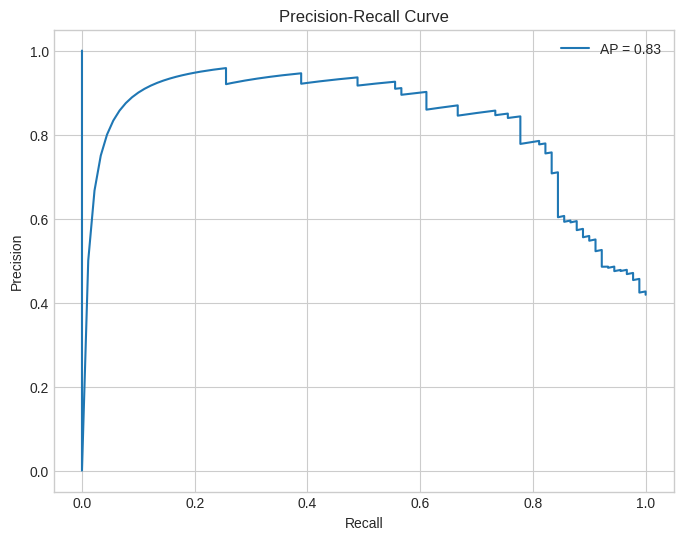

In [21]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score

# Load Titanic dataset
data = sns.load_dataset('titanic')

# Keep relevant features and drop rows with missing values
data = data[['survived', 'pclass', 'sex', 'age', 'fare']].dropna()

# Encode categorical variable 'sex' (male=1, female=0)
data['sex'] = data['sex'].map({'male': 1, 'female': 0})

# Define features and target
X = data[['pclass', 'sex', 'age', 'fare']]
y = data['survived']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities for the positive class
y_scores = model.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


21. Write a Python program to train Logistic Regression with different solvers (liblinear, saga, lbfgs) and compare
their accuracyM

In [22]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load Titanic dataset
data = sns.load_dataset('titanic')

# Select relevant columns and drop missing values
data = data[['survived', 'pclass', 'sex', 'age', 'fare']].dropna()

# Encode categorical variable 'sex'
data['sex'] = data['sex'].map({'male': 1, 'female': 0})

# Define features and target
X = data[['pclass', 'sex', 'age', 'fare']]
y = data['survived']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define solvers to compare
solvers = ['liblinear', 'saga', 'lbfgs']
accuracy_results = {}

# Train and evaluate model for each solver
for solver in solvers:
    try:
        model = LogisticRegression(solver=solver, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracy_results[solver] = acc
    except Exception as e:
        accuracy_results[solver] = f"Error: {e}"

# Print accuracy comparison
print("Accuracy Comparison of Logistic Regression Solvers:")
for solver, acc in accuracy_results.items():
    print(f"Solver: {solver.ljust(10)} => Accuracy: {acc}")


Accuracy Comparison of Logistic Regression Solvers:
Solver: liblinear  => Accuracy: 0.786046511627907
Solver: saga       => Accuracy: 0.7209302325581395
Solver: lbfgs      => Accuracy: 0.7674418604651163


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


22.Write a Python program to train Logistic Regression and evaluate its performance using Matthews
Correlation Coefficient (MCC).

In [23]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef, classification_report

# Load Titanic dataset
data = sns.load_dataset('titanic')

# Select relevant columns and drop missing values
data = data[['survived', 'pclass', 'sex', 'age', 'fare']].dropna()

# Encode categorical variable 'sex' (male=1, female=0)
data['sex'] = data['sex'].map({'male': 1, 'female': 0})

# Define features and target
X = data[['pclass', 'sex', 'age', 'fare']]
y = data['survived']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)

# Display results
print("Matthews Correlation Coefficient (MCC):", round(mcc, 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Matthews Correlation Coefficient (MCC): 0.519

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       126
           1       0.72      0.71      0.72        89

    accuracy                           0.77       215
   macro avg       0.76      0.76      0.76       215
weighted avg       0.77      0.77      0.77       215



23.Write a Python program to train Logistic Regression on both raw and standardized data. Compare their
accuracy to see the impact of feature scaling.

In [24]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load Titanic dataset
data = sns.load_dataset('titanic')

# Select relevant columns and drop rows with missing values
data = data[['survived', 'pclass', 'sex', 'age', 'fare']].dropna()

# Encode 'sex' (male=1, female=0)
data['sex'] = data['sex'].map({'male': 1, 'female': 0})

# Features and target
X = data[['pclass', 'sex', 'age', 'fare']]
y = data['survived']

# Split into train and test sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression on raw data
model_raw = LogisticRegression()
model_raw.fit(X_train_raw, y_train)
y_pred_raw = model_raw.predict(X_test_raw)
accuracy_raw = accuracy_score(y_test, y_pred_raw)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_raw)
X_test_std = scaler.transform(X_test_raw)

# Logistic Regression on standardized data
model_std = LogisticRegression()
model_std.fit(X_train_std, y_train)
y_pred_std = model_std.predict(X_test_std)
accuracy_std = accuracy_score(y_test, y_pred_std)

# Compare results
print(f"Accuracy on Raw Data:         {accuracy_raw:.3f}")
print(f"Accuracy on Standardized Data:{accuracy_std:.3f}")


Accuracy on Raw Data:         0.767
Accuracy on Standardized Data:0.758


24.Write a Python program to train Logistic Regression and find the optimal C (regularization strength) using
cross-validationM

Best C value: 0.1668100537200059
Cross-validated accuracy: 0.791


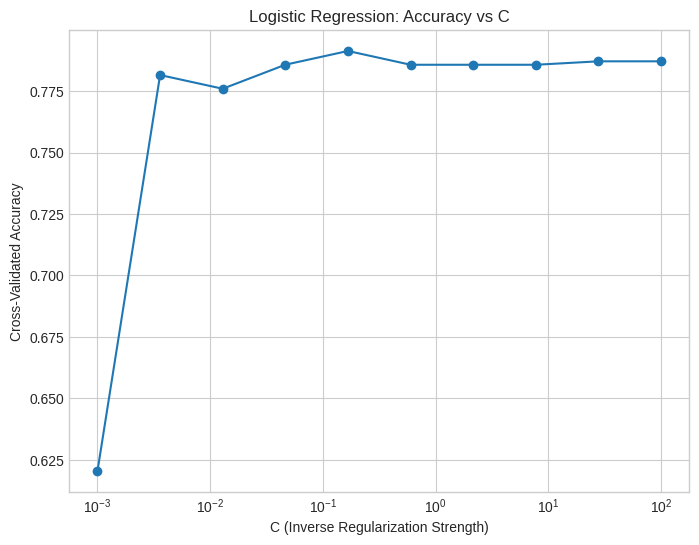

In [25]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Load Titanic dataset
data = sns.load_dataset('titanic')

# Select and clean data
data = data[['survived', 'pclass', 'sex', 'age', 'fare']].dropna()
data['sex'] = data['sex'].map({'male': 1, 'female': 0})

# Features and target
X = data[['pclass', 'sex', 'age', 'fare']]
y = data['survived']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define candidate C values (log scale)
C_values = np.logspace(-3, 2, 10)  # from 0.001 to 100
cv_scores = []

# Cross-validate for each C
for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000)
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find optimal C
best_index = np.argmax(cv_scores)
best_C = C_values[best_index]

# Print results
print(f"Best C value: {best_C}")
print(f"Cross-validated accuracy: {cv_scores[best_index]:.3f}")

# Plot accuracy vs C
plt.figure(figsize=(8, 6))
plt.semilogx(C_values, cv_scores, marker='o')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Logistic Regression: Accuracy vs C')
plt.grid(True)
plt.show()


25.Write a Python program to train Logistic Regression, save the trained model using joblib, and load it again to  make predictions.

In [26]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import joblib

# Step 1: Load and prepare the data
data = sns.load_dataset('titanic')
data = data[['survived', 'pclass', 'sex', 'age', 'fare']].dropna()
data['sex'] = data['sex'].map({'male': 1, 'female': 0})

X = data[['pclass', 'sex', 'age', 'fare']]
y = data['survived']

# Step 2: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Step 4: Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 5: Save the model and scaler
joblib.dump(model, 'logistic_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

print("Model and scaler saved successfully.")

# Step 6: Load the model and scaler
loaded_model = joblib.load('logistic_model.joblib')
loaded_scaler = joblib.load('scaler.joblib')

# Step 7: Make predictions using the loaded model
# Let's simulate predicting on the original test data (not yet scaled)
X_test_original = X_test  # Already scaled in this case

# Predict
y_pred = loaded_model.predict(X_test_original)
accuracy = accuracy_score(y_test, y_pred)

# Output result
print(f"Accuracy of loaded model: {accuracy:.3f}")


Model and scaler saved successfully.
Accuracy of loaded model: 0.758
